In [20]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib as plt

In [10]:
# Image Processing Libraries
from tqdm import tqdm  # to show processing bar
from skimage.io import imread, imshow
from skimage.transform import resize

In [6]:
''' Standard Size of Images '''
img_width = 128 
img_hight = 128
img_channels = 3
# adjust randome seed size
seed = 42
np.random.seed = seed

##  Data Preprocessing

Resizing Training Images

In [15]:
'''  
Data Preprocessing
''' 
train_path = 'stage1_train/'
test_path = 'stage1_test/'
train_ids = next(os.walk(train_path))[1]#next return a tuple(all folders at 1 position
test_ids = next(os.walk(test_path))[1]

X_train = np.zeros((len(train_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_train.shape
Y_train = np.zeros((len(train_ids),img_hight, img_width, 1), dtype=np.bool) # for Masks
# Y_train.shape
#
""" Resizing Training Images  """
#
print('Resizing Training Images and Masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path + id_
    image = imread(path + '/images/'+ id_+'.png')[:,:,:img_channels]
    image = resize(image, (img_hight, img_width), mode='constant', preserve_range= True)
    X_train[n] = image # fill empty X_train with values from images
    mask = np.zeros((img_hight, img_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        test_mask = imread(path + '/masks/' + mask_file)
        test_mask = np.expand_dims(resize(test_mask,(img_hight, img_width), mode='constant', preserve_range=True), axis=-1)#
        mask = np.maximum(mask, test_mask)
    Y_train[n] = mask


  0%|          | 0/670 [00:00<?, ?it/s]

Resizing Training Images and Masks


100%|██████████| 670/670 [14:16<00:00,  1.28s/it]


Resizing Test Images

In [17]:
X_test = np.zeros((len(test_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_test.shape
sizes_test = []
print('Resizing Test Images...')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_ + '/images/' + id_ + '.png'
    image = imread(path)[:,:,:img_channels]
    sizes_test.append([image.shape[0], image.shape[1]])
    image = resize(image, (img_hight, img_width), mode='constant', preserve_range=True)
    X_test[n] = image
print('Resizing Done!!!')

  0%|          | 0/65 [00:00<?, ?it/s]

Resizing Test Images...


100%|██████████| 65/65 [00:05<00:00, 11.01it/s]

Resizing Done!!!


In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/zawster/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


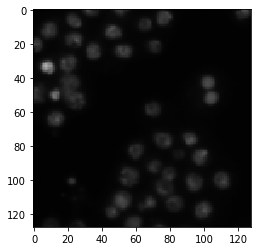

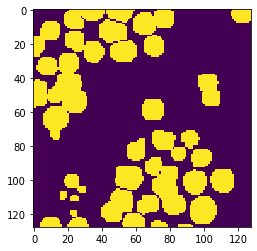

In [46]:
# Ploting Some Random Images
# image_x = 658
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x]) # showing image
plt.show()
imshow(np.squeeze(Y_train[image_x])) # show coresponding mask
plt.show()


Build the Model (Creating Neural Network)

In [48]:
# Build the Model
inputs = tf.keras.layers.Input((img_width, img_hight, img_channels)) # Input Layer
float_Values = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting each value into flot for Neural Network
# Contraction path (going down)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(float_Values)
c1 = tf.keras.layers.Dropout(0.1)(c1) # dropout of 10%
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) # creating new Layer
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)  # MaxPolling layer

c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout((0.2))(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

Up Scallig

In [49]:
#Expensive Path (Up Scalling)
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)##
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)##
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (2,2), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (2,2), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
# Output layer
outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Compiling Model

In [59]:
# Compiling Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')#, matrices=['accuracy'])  #optimize contais  Back propagation

Model Summary

In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 128, 128, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 128, 128, 16) 448         lambda_15[0][0]                  
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 128, 128, 16) 0           conv2d_84[0][0]                  
____________________________________________________________________________________________

ModelCheckpoints and Callbacks

In [62]:
# ModelCheckpoints
checkPointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkPointer
]

Fitting the Model 

In [61]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)#

Train on 603 samples, validate on 67 samples
Epoch 1/25
603/603 [==============================] - 159s 264ms/sample - loss: 0.5894 - val_loss: 0.4162
Epoch 2/25
603/603 [==============================] - 150s 249ms/sample - loss: 0.3192 - val_loss: 0.2753
Epoch 3/25
603/603 [==============================] - 139s 230ms/sample - loss: 0.2337 - val_loss: 0.1930
Epoch 4/25
603/603 [==============================] - 134s 222ms/sample - loss: 0.1706 - val_loss: 0.1397
Epoch 5/25
603/603 [==============================] - 142s 235ms/sample - loss: 0.1472 - val_loss: 0.1495
Epoch 6/25
603/603 [==============================] - 139s 230ms/sample - loss: 0.1287 - val_loss: 0.1253
Epoch 7/25
603/603 [==============================] - 142s 235ms/sample - loss: 0.1196 - val_loss: 0.1026
Epoch 8/25
603/603 [==============================] - 152s 253ms/sample - loss: 0.1139 - val_loss: 0.1110
Epoch 9/25
603/603 [==============================] - 134s 222ms/sample - loss: 0.1070 - val_loss: 0.0994
E

#### Validation (Testing)

In [70]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


65/65 [==============================] - 5s 70ms/sample


Actual Spot Nuclei Image:


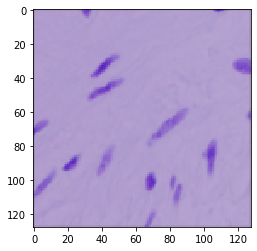

Expected Infected Region:


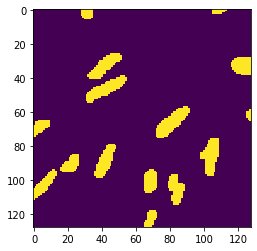

Predicted Result:


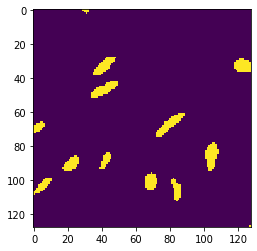

In [71]:
# perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print('Actual Spot Nuclei Image:')
imshow(X_train[ix])
plt.show()
print('Expected Infected Region:')
imshow(np.squeeze(Y_train[ix]))
plt.show()
print('Predicted Result:')
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

Actual Spot Nuclei Image:


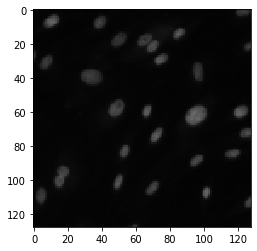

Expected Infected Region:


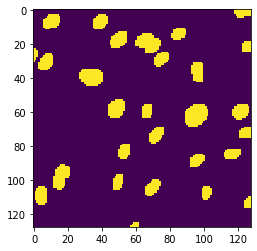

Predicted Result:


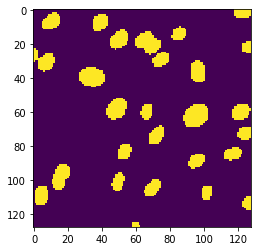

In [72]:
# perform a sanity check on some random validating samples
ix = random.randint(0,len(preds_val_t))
print('Actual Spot Nuclei Image:')
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
print('Expected Infected Region:')
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
print('Predicted Result:')
imshow(np.squeeze(preds_val_t[ix]))
plt.show()